In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 500
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from pylab import rcParams
rcParams['figure.figsize'] = 6,3
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

import gc
gc.collect()

0

In [ ]:
df=pd.read_csv('train-10.csv')

from pandas.io.json import json_normalize
import json

def load_df(csv_path='train-9.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [2]:
train_df = load_df()
train_df.to_csv('train-11.csv')

# Прочитаем данные ( уже преобразованные)
tdf=pd.read_csv('train-11.csv')

# Преобразуем формат даты
tdf['date'] = pd.to_datetime(tdf['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
tdf['weekday']=tdf['date'].apply(lambda x: x.weekday() )  

def Isweekend(row):
    if row['weekday'] == 5:
        return 'weekend'
    if row['weekday'] == 6:
        return 'weekend'
    else: 
        return'work_days'
    
tdf['IsWeekend']=tdf.apply(Isweekend, axis=1)
tdf['date1']=tdf['date'].apply(lambda x: x.strftime("%Y-%m") )  

In [3]:
# Преобразуем категорию источника траффика

def Traf_sourse(row):
    x = str(row).lower()
    if 'mail' in row:
        return 'mail'
    
    if 'mail' not in row: 
        if 'google' in x:
            return 'google'
        if 'facebook' in row:
            return 'facebook'
        if 'yahoo' in row:
            return 'yahoo'
        if 'bing' in row:
            return 'bing'
        if 'reddit' in row:
            return 'reddit'
        if 'baidu' in row:
            return 'baidu'
        if 'yandex' in row:
            return 'yandex'
        else:
            return 'other'
        
tdf['trafficSource.source1'] = tdf['trafficSource.source'].apply(Traf_sourse)

In [4]:
tdf.head() 

,Unnamed: 0,Unnamed: 0.1,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,IsWeekend,date1,trafficSource.source1
0,0,0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,4,work_days,2016-09,google
1,1,1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,4,work_days,2016-09,google
2,2,2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,4,work_days,2016-09,google
3,3,3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google,4,work_days,2016-09,google
4,4,4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google,4,work_days,2016-09,google


In [180]:
df1 = tdf[[x for x in tdf.columns if 'totals.transactionRevenue' in x] + ['device.deviceCategory']]\
    .groupby('device.deviceCategory').sum()
df1.head()

,totals.transactionRevenue
device.deviceCategory,
desktop,1.480864e+12
mobile,4.978581e+10
tablet,9.421340e+09


In [52]:
#Динамика заходов и покупок

one=tdf.groupby(['date'])['visitNumber'].count().reset_index()
tdf2=tdf[tdf['totals.transactionRevenue']>0]
two=tdf2.groupby(['date'])['totals.transactionRevenue'].count().reset_index()

layout = go.Layout(
    yaxis=dict(title='Count visits'),
    yaxis2=dict(title='Count transactions', overlaying='y', side='right')
)
trace0 = go.Scatter(
    x=one['date'],
    y=one['visitNumber'],
    name='Total',
    yaxis='y1'
)
trace1 = go.Scatter(
    x=two['date'],
    y=two['totals.transactionRevenue'],
    name='With_revenue',
    yaxis='y2'
)
data = [trace0, trace1]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [7]:
# Интересный факт, что В  период с октября по докабрь было много посещений сайта, 
# но покупок было обычное значение. Далее Исследуем это.

In [8]:
#динамика среднего чека

tdf2=tdf[tdf['totals.transactionRevenue']>0]
two=tdf2.groupby(['date'])['totals.transactionRevenue'].count().reset_index()

three=tdf2.groupby(['date'])['totals.transactionRevenue'].sum().reset_index()

layout = go.Layout(
    yaxis=dict(title='Count visits'),
    yaxis2=dict(title='Count transactions', overlaying='y', side='right')
)
trace0 = go.Scatter(
    x=three['date'],
    y=three['totals.transactionRevenue'],
    name='Sum',
    yaxis='y1'
)
trace1 = go.Scatter(
    x=two['date'],
    y=two['totals.transactionRevenue'],
    name='Count',
    yaxis='y2'
)
data = [trace0, trace1]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [9]:
#  Средний ек по всему времени в принципе повторяет спрос, но есть даты: 15 сентября и 5 апреля, 
# когда были значения аномальными (как дальше выяснилось, были единичные большие закупки (опт скорее 
# всего, тк sourse был бизнес-журнал))

In [290]:
a[a['totals.transactionRevenue']==max(a['totals.transactionRevenue'])]

,Unnamed: 0,Unnamed: 0.1,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
375253,375253,375253,Display,2017-04-05,1957458976293878100,1957458976293878100_1491423580,1491423580,243,1491423580,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,NaN,58,NaN,40.0,2.312950e+10,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,cpm,NaN,dfa


In [11]:
#Проверим зависимость новых клиентов и всх заходов
NewVisiters=tdf.groupby(['date'])['totals.newVisits'].count().reset_index()
one=tdf.groupby(['date'])['totals.visits'].count().reset_index()

trace0 = go.Scatter( x=NewVisiters['date'], y=NewVisiters['totals.newVisits'], name='New visiters', yaxis='y1')
trace1= go.Scatter( x=one['date'], y=one['totals.visits'], name='All visiters', yaxis='y1')
data = [trace0, trace1]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [13]:
# пох что одостаточно ровное распределение относительно друг друга

In [9]:
tdf[tdf['geoNetwork.networkDomain'] == 'comcastbusiness.net']

,Unnamed: 0,Unnamed: 0.1,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
206,206,206,Referral,2016-09-02,780206376162514125,0780206376162514125_1472850326,1472850326,2,1472850326,Chrome,desktop,False,Macintosh,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,1.0,1,NaN,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/,mall.googleplex.com
427,427,427,Affiliates,2016-09-02,6981494671507756425,6981494671507756425_1472845230,1472845230,1,1472845230,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,NaN,3,1.0,3.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Data Share Promo,NaN,NaN,NaN,affiliate,NaN,Partners
456,456,456,Referral,2016-09-02,4476310736925236393,4476310736925236393_1472832250,1472832250,2,1472832250,Chrome,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,comcastbusiness.net,California,Northern America,NaN,4,NaN,4.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,referral,/,mall.googleplex.com
634,634,634,Affiliates,2016-09-02,7561424719313117063,7561424719313117063_1472830249,1472830249,1,1472830249,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,NaN,8,1.0,5.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Data Share Promo,NaN,NaN,NaN,affiliate,NaN,Partners
770,770,770,Organic Search,2016-09-02,2109646448307820292,2109646448307820292_1472840936,1472840936,6,1472840936,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,NaN,12,NaN,8.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google
848,848,848,Direct,2016-09-02,4972598071143292913,4972598071143292913_1472827870,1472827870,1,1472827870,Chrome,desktop,False,Windows,Salem,Americas,United States,Roanoke-Lynchburg VA,comcastbusiness.net,Virginia,Northern America,NaN,16,1.0,11.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
899,899,899,Direct,2016-09-02,3313704080382094426,3313704080382094426_1472843235,1472843235,1,1472843235,Firefox,desktop,False,Macintosh,Salem,Americas,United States,Roanoke-Lynchburg VA,comcastbusiness.net,Virginia,Northern America,NaN,19,1.0,17.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
921,921,921,Organic Search,2016-09-02,1957458976293878100,1957458976293878100_1472841771,1472841771,85,1472841771,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,NaN,22,NaN,16.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google
992,992,992,Direct,2016-09-02,563963070031405352,0563963070031405352_1472842593,1472842593,10,1472842593,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo d

In [14]:
# Делаем различне фильтры
q=tdf[tdf['channelGrouping']=='Referral']
w=tdf[tdf['channelGrouping']=='Organic Search']
e=tdf[tdf['channelGrouping']=='Direct']
h=tdf[tdf['channelGrouping']=='Social']


r=tdf[tdf['device.operatingSystem']=='Macintosh']
t=tdf[tdf['device.operatingSystem']=='Windows']

y=tdf[tdf['geoNetwork.city']=='not available in demo dataset']
u=tdf[tdf['geoNetwork.city']=='New York']
i=tdf[tdf['geoNetwork.city']=='Mountain View']





In [19]:
# Построим график заходв на сайт по Channel Grouping

q=tdf[tdf['channelGrouping']=='Referral']
w=tdf[tdf['channelGrouping']=='Organic Search']
e=tdf[tdf['channelGrouping']=='Direct']
h=tdf[tdf['channelGrouping']=='Social']

one=q.groupby(['date'])['totals.newVisits'].count().reset_index()
two=w.groupby(['date'])['totals.newVisits'].count().reset_index()
thr=e.groupby(['date'])['totals.newVisits'].count().reset_index()
fo=h.groupby(['date'])['totals.newVisits'].count().reset_index()

trace0 = go.Scatter( x=one['date'], y=one['totals.newVisits'], name='Referal', yaxis='y1')
trace1= go.Scatter( x=two['date'], y=two['totals.newVisits'], name='Organic', yaxis='y1')
trace2= go.Scatter( x=thr['date'], y=thr['totals.newVisits'], name='Direct', yaxis='y1')
trace3= go.Scatter( x=fo['date'], y=fo['totals.newVisits'], name='Social', yaxis='y1')

layout = go.Layout(
yaxis=dict(title='Conversion rate'),
yaxis2=dict(title='Count transactions', overlaying='y', side='right'),
title='Channel Grouping' )

data = [trace0, trace1, trace2, trace3]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [16]:
# Как оказалось, в тот перод с октября по декабрь была запущена реклама по социальным медиа. 
# В дальнейшем проверим, на сколько эффекивно это было

In [17]:
o=tdf[tdf['trafficSource.medium']=='referral']
p=tdf[tdf['trafficSource.medium']=='organic']
a=tdf[tdf['trafficSource.medium']=='(none)']
s=tdf[tdf['trafficSource.medium']=='cpc']

one=o.groupby(['date'])['totals.newVisits'].count().reset_index()
two=p.groupby(['date'])['totals.newVisits'].count().reset_index()
thr=a.groupby(['date'])['totals.newVisits'].count().reset_index()
fo=s.groupby(['date'])['totals.newVisits'].count().reset_index()

trace0 = go.Scatter( x=one['date'], y=one['totals.newVisits'], name='referral', yaxis='y1')
trace1= go.Scatter( x=two['date'], y=two['totals.newVisits'], name='organic', yaxis='y1')
trace2= go.Scatter( x=thr['date'], y=thr['totals.newVisits'], name='(none)', yaxis='y1')
trace3= go.Scatter( x=fo['date'], y=fo['totals.newVisits'], name='cpc', yaxis='y1')

layout = go.Layout(
yaxis=dict(title='Conversion rate'),
yaxis2=dict(title='Count transactions', overlaying='y', side='right'),
title='traffic Source Medium' )

data = [trace0, trace1, trace2, trace3]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [18]:
# Видим, что весь SMM из реферальных ссылок пришел, остальные каналы работают стабильно

In [21]:
# Построим по источнику
d=tdf[tdf['trafficSource.source']=='mall.googleplex.com']
f=tdf[tdf['trafficSource.source']=='google']
g=tdf[tdf['trafficSource.source']=='(direct)']

one=d.groupby(['date'])['totals.newVisits'].count().reset_index()
two=f.groupby(['date'])['totals.newVisits'].count().reset_index()
thr=g.groupby(['date'])['totals.newVisits'].count().reset_index()


trace0 = go.Scatter( x=one['date'], y=one['totals.newVisits'], name='mall.googleplex.com', yaxis='y1')
trace1= go.Scatter( x=two['date'], y=two['totals.newVisits'], name='google', yaxis='y1')
trace2= go.Scatter( x=thr['date'], y=thr['totals.newVisits'], name='(direct)', yaxis='y1')
layout = go.Layout(
yaxis=dict(title='Conversion rate'),
yaxis2=dict(title='Count transactions', overlaying='y', side='right'),
title='traffic Source ' )

data = [trace0, trace1, trace2]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [87]:
one=d.groupby(['date1'])['totals.newVisits'].count().reset_index()
two=f.groupby(['date1'])['totals.newVisits'].count().reset_index()
thr=g.groupby(['date1'])['totals.newVisits'].count().reset_index()


trace0 = go.Scatter( x=one['date1'], y=one['totals.newVisits'], name='one', yaxis='y1')
trace1= go.Scatter( x=two['date1'], y=two['totals.newVisits'], name='two', yaxis='y1')
trace2= go.Scatter( x=thr['date1'], y=thr['totals.newVisits'], name='thr', yaxis='y1')


data = [trace0, trace1, trace2]
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [66]:
for i in ('channelGrouping', 'device.browser','device.deviceCategory','device.operatingSystem',
          'trafficSource.adContent', 'trafficSource.campaign','trafficSource.medium', 'trafficSource.source1', 'IsWeekend'):
    
    col= tdf.groupby([i])['totals.transactionRevenue'].count().reset_index()
    col2= tdf.groupby([i])['totals.hits'].count().reset_index()
    col2['new']=col['totals.transactionRevenue']/col2['totals.hits']    
    col3 = col.merge(col2 , on=i, how='left')
    col3 = col3[col3['totals.transactionRevenue']>0]
    col3=col3[col3['new']>0]
    col3=col3[col3['totals.hits']>1000]
    col3=col3.sort_values('totals.hits', ascending=False)
    
    trace0 = go.Scatter( x=col3[i], y=col3['new'], name='one', yaxis='y1')
    trace1= go.Bar(x=col3[i], y=col3['totals.hits'], name='two', yaxis='y2',opacity=0.6)
    trace2= go.Bar(x=col3[i], y=col3['totals.transactionRevenue'], name='three', yaxis='y2')
    
    layout = go.Layout(
    yaxis=dict(title='Conversion rate'),
    yaxis2=dict(title='Count transactions', overlaying='y', side='right'),
    title=i )

    data = [trace0, trace1, trace2] ; fig = go.Figure(data=data, layout=layout) ;iplot(fig, show_link=False)

In [57]:
avch=tdf.groupby(['channelGrouping'])['totals.transactionRevenue'].agg({'sum','count'}).reset_index()
avch['AvPrice']=avch['sum']/avch['count']
avch.sort_values('AvPrice', ascending=False).style.bar('AvPrice')

,channelGrouping,count,sum,AvPrice
3,Display,142,7.83375e+10,5.51672e+08
2,Direct,2042,4.34841e+11,2.12948e+08
6,Referral,5311,6.5143e+11,1.22657e+08
4,Organic Search,3438,3.26381e+11,9.49332e+07
5,Paid Search,468,4.35589e+10,9.30746e+07
1,Affiliates,9,5.9738e+08,6.63756e+07
7,Social,104,4.91654e+09,4.72744e+07
0,(Other),1,9.99e+06,9.99e+06


In [50]:
# Самый низкий чек приходится на канал Social, а самый высокий на Display

In [56]:
# Средний чек по  traffic Source Мedium
avch=tdf.groupby(['trafficSource.medium'])['totals.transactionRevenue'].agg({'sum','count'}).reset_index()
avch['AvPrice']=avch['sum']/avch['count']
avch.sort_values('AvPrice', ascending=False).style.bar('AvPrice')

,trafficSource.medium,count,sum,AvPrice
4,cpm,142,7.83375e+10,5.51672e+08
0,(none),2042,4.34841e+11,2.12948e+08
6,referral,5415,6.56346e+11,1.21209e+08
5,organic,3438,3.26381e+11,9.49332e+07
3,cpc,468,4.35589e+10,9.30746e+07
2,affiliate,9,5.9738e+08,6.63756e+07
1,(not set),1,9.99e+06,9.99e+06


In [51]:
# Самый низкий чек приходится на канал (not set), а самый высокий на cpm

In [60]:
# Средний чек по  Операционным системам
avch=tdf.groupby(['device.operatingSystem'])['totals.transactionRevenue'].agg({'sum','count'}).reset_index()
avch['AvPrice']=avch['sum']/avch['count']
avch.sort_values('AvPrice', ascending=False).head(5).style.bar('AvPrice')

,device.operatingSystem,count,sum,AvPrice
3,Chrome OS,994,1.83938e+11,1.85048e+08
16,Windows,2309,3.97313e+11,1.72071e+08
7,Macintosh,6426,8.56376e+11,1.33267e+08
1,Android,467,3.63413e+10,7.78186e+07
6,Linux,782,4.39104e+10,5.61514e+07


In [62]:
# Средний чек по  контенту
avch=tdf.groupby(['trafficSource.adContent'])['totals.transactionRevenue'].agg({'sum','count'}).reset_index()
avch['AvPrice']=avch['sum']/avch['count']
avch.sort_values('AvPrice', ascending=False).head(5).style.bar('AvPrice')

,trafficSource.adContent,count,sum,AvPrice
17,Google Merchandise Collection,117,1.49583e+10,1.27849e+08
6,Display Ad created 3/11/14,3,3.0231e+08,1.0077e+08
39,{KeyWord:Google Men's T-Shirts},1,7.782e+07,7.782e+07
35,{KeyWord:Google Branded Gear},3,2.2424e+08,7.47467e+07
10,Full auto ad IMAGE ONLY,5,2.6238e+08,5.2476e+07


In [63]:
# Средний чек по  контенту
avch=tdf.groupby(['IsWeekend'])['totals.transactionRevenue'].agg({'sum','count'}).reset_index()
avch['AvPrice']=avch['sum']/avch['count']
avch.sort_values('AvPrice', ascending=False).head(5).style.bar('AvPrice')

,IsWeekend,count,sum,AvPrice
1,work_days,9786,1.40583e+12,1.43657e+08
0,weekend,1729,1.34239e+11,7.76397e+07


In [65]:
# Средний чек по  контенту
avch=tdf.groupby(['date1'])['totals.transactionRevenue'].agg({'sum','count'}).reset_index()
avch['AvPrice']=avch['sum']/avch['count']
avch.sort_values('AvPrice', ascending=False).head(5).style.bar('AvPrice')

,date1,count,sum,AvPrice
12,2017-08,43,8.30494e+09,1.93138e+08
8,2017-04,928,1.58789e+11,1.71109e+08
6,2017-02,708,1.08757e+11,1.53611e+08
7,2017-03,883,1.30964e+11,1.48317e+08
1,2016-09,859,1.26031e+11,1.46719e+08


In [68]:
#  Оценим доходы по ключевым словам 
col= tdf.groupby(['trafficSource.keyword'])['totals.transactionRevenue'].count().reset_index()
col2= tdf.groupby(['trafficSource.keyword'])['fullVisitorId'].count().reset_index()
col2['new']=col['totals.transactionRevenue']/col2['fullVisitorId']    
col3 = col.merge(col2 , on='trafficSource.keyword', how='left')
col3=col3.sort_values('totals.transactionRevenue', ascending=False)
col3.sort_values('totals.transactionRevenue', ascending=False).head(5).style.bar('totals.transactionRevenue')

,trafficSource.keyword,totals.transactionRevenue,fullVisitorId,new
11,(not provided),3387,366363,0.00924493
95,6qEhsCssdK0z36ri,261,11503,0.0226897
1420,google merchandise store,59,2209,0.0267089
85,1hZbAqLCbjwfgOH7,56,2264,0.024735
198,Google Merchandise,45,1648,0.0273058


In [133]:
for i in ('geoNetwork.city', 'geoNetwork.country','geoNetwork.region','geoNetwork.subContinent',
 'trafficSource.source','trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType',):
    

    col= tdf.groupby([i])['totals.transactionRevenue'].count().reset_index()
    col2= tdf.groupby([i])['fullVisitorId'].count().reset_index()
    col2['new']=col['totals.transactionRevenue']/col2['fullVisitorId']    
    col3 = col.merge(col2 , on=i, how='left')
    col3 = col3[col3['totals.transactionRevenue']>100]
    col3=col3[col3['new']>0]
    col3=col3[col3['fullVisitorId']>1000]
    col3=col3.sort_values('fullVisitorId', ascending=False)
    
    trace0 = go.Scatter( x=col3[i], y=col3['new'], name='one', yaxis='y1')
    trace1= go.Bar(x=col3[i], y=col3['fullVisitorId'], name='two', yaxis='y2',opacity=0.6)
    trace2= go.Bar(x=col3[i], y=col3['totals.transactionRevenue'], name='three', yaxis='y2')
    
    layout = go.Layout(
    yaxis=dict(title='Conversion rate'),
    yaxis2=dict(title='Count transactions', overlaying='y', side='right'),
    title=i )

    data = [trace0, trace1, trace2] ; fig = go.Figure(data=data, layout=layout) ;iplot(fig, show_link=False)

In [ ]:
# Сделать автоматический генератор графиков

In [45]:
# Видно, что во многих запросах присутсвует слово google. Сгруппируем по нему и посмотрим
def add_new_category(x):
    x = str(x).lower()
    if x == 'nan':
        return 'nan'
    
    x = ''.join(x.split())
    
    if 'youtube' in x or 'you' in x or 'yo' in x or 'tub' in x:
        return 'youtube'
    elif 'google' in x or 'goo' in x or 'gle' in 'x':
        return 'google'
    else:
        return 'other'
tdf['trafficSource.keyword1'] = tdf['trafficSource.keyword'].apply(add_new_category)

col= tdf.groupby(['trafficSource.keyword1'])['totals.transactionRevenue'].count().reset_index()
col2= tdf.groupby(['trafficSource.keyword1'])['fullVisitorId'].count().reset_index()
col2['new']=col['totals.transactionRevenue']/col2['fullVisitorId']    
col3 = col.merge(col2 , on='trafficSource.keyword1', how='left')
col3=col3.sort_values('totals.transactionRevenue', ascending=False)
col3.head()

,trafficSource.keyword1,totals.transactionRevenue,fullVisitorId,new
1,nan,7644,502929,0.015199
2,other,3722,385614,0.009652
0,google,143,10932,0.013081
3,youtube,6,4178,0.001436


In [46]:
# из анализа ключевых слов похоже, что самым прибыльными сочетаниями является 
# "google merchandise store" и "Google Merchandise" А группировка не дала ничего полезного.

In [36]:
citi=tdf.groupby(['geoNetwork.continent'])['geoNetwork.country'].count().reset_index()
data = []

for genre in citi['geoNetwork.continent'].unique():
    data.append(
        go.Bar(y=citi[citi['geoNetwork.continent']==genre]['geoNetwork.country'], 
               name=genre)
    )
iplot(data, show_link = True)

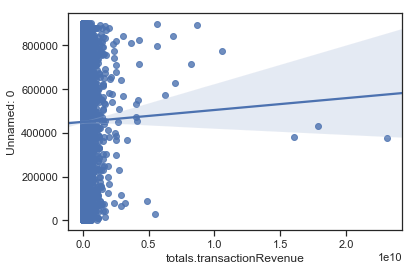

In [25]:
sns.regplot(x="totals.transactionRevenue", y="Unnamed: 0", data=tdf);

In [24]:
# Видно, что все розничные заказы группируются до 0.4 А все что выше - оптовые.

In [ ]:
k=tdf[tdf['totals.transactionRevenue']>0]
c=k[k['totals.transactionRevenue']<110000000]
sns.catplot(x="device.deviceCategory", y="totals.transactionRevenue", kind="box", data=tdf);

# Продолжение следует...